### **Обучение модели**

Используем предобученную модель xlm-roberta-base

Она не слишком велика, при этом обладает достаточно сложной архитектурой для нашей цели

***
**Работа с данными**

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=c90a60e11e02178a20409ed5707184636cace844768d942252312422dda0eeb3
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    Trainer, TrainingArguments, DataCollatorForTokenClassification
)

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import evaluate
import torch
from seqeval.metrics import classification_report
from torch.nn import CrossEntropyLoss
from collections import defaultdict

In [ ]:
df = pd.read_pickle('data_label.pkl')
print(df.isnull().sum()) # проверка на пустые токены и метки
display(df.head(3))

tokens    0
labels    0
dtype: int64


,tokens,labels
0,"[верблю, ##дов, то, за, что, дебил, ##ы, бл]","[O, O, O, O, O, B-PRF, I-PRF, B-PRF]"
1,"[хох, ##лы, это, от, ##ду, ##шина, зат, ##юка,...","[B-PRF, I-PRF, O, O, O, O, O, O, O, O, O, O, O..."
2,"[собаке, соба, ##чья, смерть]","[O, O, O, O]"


In [ ]:
# Проверка на несоответствие длины токенов и меток
assert all(len(t) == len(l) for t, l in zip(df['tokens'], df['labels']))

In [ ]:
# Созадим словарь меток
label_list = ['O', 'B-PRF', 'I-PRF']
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {value: key for key, value in label2id.items()}

In [ ]:
# Функция конвертации меток в id
def convert_labels_to_ids(labels_list, labels_to_id):
    return [label2id[label] for label in labels_list]

# Кодировка
df['ner_tags'] = df['labels'].apply(lambda x: convert_labels_to_ids(x, label2id))
display(df.head(3))

,tokens,labels,ner_tags
0,"[верблю, ##дов, то, за, что, дебил, ##ы, бл]","[O, O, O, O, O, B-PRF, I-PRF, B-PRF]","[0, 0, 0, 0, 0, 1, 2, 1]"
1,"[хох, ##лы, это, от, ##ду, ##шина, зат, ##юка,...","[B-PRF, I-PRF, O, O, O, O, O, O, O, O, O, O, O...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[собаке, соба, ##чья, смерть]","[O, O, O, O]","[0, 0, 0, 0]"


In [ ]:
# Разделение данных
temp_data, test_data = train_test_split(df[['tokens', 'ner_tags']], test_size=0.15, random_state=42)
train_data, val_data = train_test_split(temp_data, test_size=0.15, random_state=42)
print(f'Датасеты: train = {len(train_data)}, val = {len(val_data)}, test = {len(test_data)}')

Датасеты: train = 13101, val = 2312, test = 2721


In [ ]:
# Преобразуем в HuggingFace датасет
ds = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'val': Dataset.from_pandas(val_data),
    'test': Dataset.from_pandas(test_data)
})

***
###**Токенизация и сопоставление меток**

In [76]:
model_checkpoint = "xlm-roberta-base"  # или другая модель
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
label_list = ['O', 'B-PRF', 'I-PRF']  # Соответствует меткам 0, 1, 2

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=256
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Специальный токен для игнорирования
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # Игнорируем подтокены
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Применяем токенизацию ко всем данным
tokenized_ds = ds.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/13101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2312 [00:00<?, ? examples/s]

Map:   0%|          | 0/2721 [00:00<?, ? examples/s]

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
# Необходимо добавить веса, т.к. очень мало B-PRF и I-PRF
label_counts = {'O': 539780, 'B-PRF': 3647, 'I-PRF': 3350} # данные из data_preparation
label_list = ['O', 'B-PRF', 'I-PRF']

# 1. Рассчитываем веса для каждого класса (обратно пропорционально частоте)
class_weights = torch.tensor([
    1.0,  # вес для 'O'
    (label_counts['O'] / label_counts['B-PRF']) * 3,
    (label_counts['O'] / label_counts['I-PRF']) * 3
], dtype=torch.float32).to(device)
print("Веса классов:", class_weights)

Веса классов: tensor([  1.0000, 444.0197, 483.3851], device='cuda:0')


In [79]:
# Кастомный Trainer с Weighted Loss
from torch.nn.modules.loss import _WeightedLoss
class FocalLoss(_WeightedLoss):
    def __init__(self, weight=None, gamma=2.0):
        super().__init__(weight)
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = CrossEntropyLoss(weight=self.weight)(inputs, targets)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

loss_fct = FocalLoss(weight=class_weights, gamma=2.0)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        if labels is None:
            labels = inputs.pop("labels")  # Для разных версий transformers

        outputs = model(**inputs)
        logits = outputs.logits

        # Убедимся, что размерности совпадают
        loss = loss_fct(
            logits.view(-1, len(label_list)),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

In [88]:
# Функция вычисления метрик
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Фильтрация меток и предсказаний (игнорируем -100)
    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    report = classification_report(true_labels, true_predictions, output_dict=True)

    return {
        'precision': report['micro avg']['precision'],
        'recall': report['micro avg']['recall'],
        'f1': report['micro avg']['f1-score'],
    }

***
###**Обучение модели**

In [89]:
output_dir = os.path.join("bert-finetuned-ner", model_checkpoint)
os.makedirs(output_dir, exist_ok=True)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label={0: 'O', 1: 'B-PRF', 2: 'I-PRF'},
    label2id={'O': 0, 'B-PRF': 1, 'I-PRF': 2}
).to(device)

class_weights = class_weights.to(model.device)
data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy='epoch',
    save_strategy='epoch',
    report_to='none',
    learning_rate=7e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    load_best_model_at_end=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-89-481395763.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [90]:
from collections import Counter
print("Метки в train:", Counter(tag for seq in train_data['ner_tags'] for tag in seq))
print("Метки в val:", Counter(tag for seq in val_data['ner_tags'] for tag in seq))

Метки в train: Counter({0: 387745, 1: 2564, 2: 2344})
Метки в val: Counter({0: 67833, 1: 468, 2: 429})


In [91]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.103500,0.006769,0.049900,0.991209,0.095017
2,0.014100,0.016415,0.257840,0.975824,0.407901
3,0.016200,0.029380,0.327675,0.975824,0.490608
4,0.003100,0.020676,0.307060,0.984615,0.468130
5,0.000400,0.029980,0.346243,0.982418,0.512027


TrainOutput(global_step=4095, training_loss=0.020948472919945532, metrics={'train_runtime': 4173.7661, 'train_samples_per_second': 15.694, 'train_steps_per_second': 0.981, 'total_flos': 8558199398453760.0, 'train_loss': 0.020948472919945532, 'epoch': 5.0})

***

In [92]:
trainer.save_model('models/profanity-ner')
tokenizer.save_pretrained('models/profanity-ner')

('models/profanity-ner/tokenizer_config.json',
 'models/profanity-ner/special_tokens_map.json',
 'models/profanity-ner/sentencepiece.bpe.model',
 'models/profanity-ner/added_tokens.json',
 'models/profanity-ner/tokenizer.json')

***
### **Итог**
Модель научилась находить почти всю нецензурную лексику (высокий recall). Однако, она часто ошибается, находя нецензурное слово там, где его нет (низкий precision).

Однако, такое поведение соответствует поставленной цели работы. Лучше зацензурить лишнее, чем пропустить нецензурную брань.

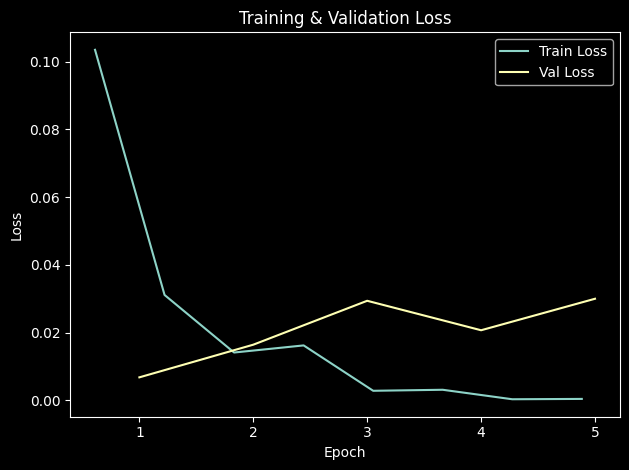

In [99]:
# Визуализация потерь
logs = trainer.state.log_history
train_loss = [x['loss'] for x in logs if 'loss' in x and 'epoch' in x]
eval_loss  = [x['eval_loss'] for x in logs if 'eval_loss' in x]
epochs     = [x['epoch'] for x in logs if 'loss' in x and 'epoch' in x]

plt.style.use('dark_background')
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(range(1, len(eval_loss)+1), eval_loss, label='Val Loss', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()